In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
import pingouin as pg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

In [ ]:
df = pd.read_csv('../../results/results.csv')
print(len(df[df['pkg_energy'] < 0]))
df = df[df['pkg_energy'] >= 0]
print(len(df['pkg_energy']))

flags = df['flag'].unique()
progs = df['program'].unique()

print(f'Flags: {len(flags)}')
print(flags)
print(f'Programs: {len(progs)}')
print(progs)

# print(df[df['pkg_energy'] < 0])


In [ ]:
# remove outliers
col = 'pkg_energy'
total_outliers = 0

for prog in progs:
    for flag in flags:
        data = df[(df['program'] == prog) & (df['flag'] == flag)]
        q75, q25 = np.percentile(data.loc[:,col],[75,25])
        intr_qr = q75 - q25

        max = q75 + (1.5 * intr_qr)
        min = q25 - (1.5 * intr_qr)

        data.loc[data[col] < min,col] = np.nan
        data.loc[data[col] > max,col] = np.nan

        outliers_count = data[col].isnull().sum()
        total_outliers += outliers_count

        # remove outliers
        df[(df['program'] == prog) & (df['flag'] == flag)] = data.dropna(axis=0)

print(f'Removed a total of {total_outliers} outliers')

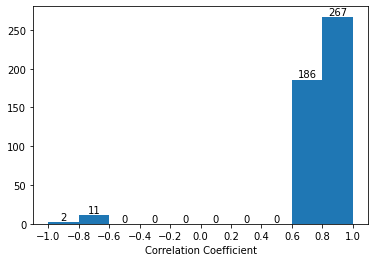

In [14]:
# Perform Spearman's test
# Calculate Spearman's correlation coefficient

# -1 <= correlation <= 1
# positive => as x increases, so does y
# negative => as x increases, y decreases

# .00-.19 => very weak
# .20-.39 => weak
# .40-.59 => moderate
# .60-.79 => strong
# .80-1.0 => very strong

df = pd.read_csv('../../results/results.csv')


corr_df = []
for prog in progs:
    for flag in flags:
        data = df[(df['flag'] == flag) & (df['program'] == prog)]
        corr, pvalue = stats.spearmanr(data['pkg_energy'], data['execution_time'])
        # corr_df.append([prog, flag, abs(corr), pvalue])
        corr_df.append([prog, flag, corr, pvalue])

corr_df = pd.DataFrame(corr_df, columns=['program', 'flag', 'correlation', 'pvalue'])
corr_df = corr_df[(corr_df['pvalue'] < 0.05)]
# print(corr_df)

bins = [-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1]
# chart = sns.histplot(corr_df, x='correlation', bins=bins).set(xlabel='Correlation Coefficient', xticks=bins)
counts, edges, bars = plt.hist(x=corr_df['correlation'], bins=bins)
plt.xticks(bins)
plt.xlabel('Correlation Coefficient')
# plt.ylabel('')
# plt.grid()
plt.bar_label(bars)
plt.savefig("../../results/charts/random/energy-time-corr.pdf")

# plt.show()


# for i in range(0, len(bins) - 1):
    # data = corr_df[(corr_df['correlation'] > bins[i]) & (corr_df['correlation'] < bins[i + 1])]
    # count = len(data)
    # print(f'[{bins[i]}, {bins[i+1]}] \t {count} \t {data["program"].values}')


/home/bernas/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Spearman's results 	| coef: 0.9973470064923231 pvalue: 0.0
Pearson's results 	| coef: 0.9683251330563797 pvalue: 0.0


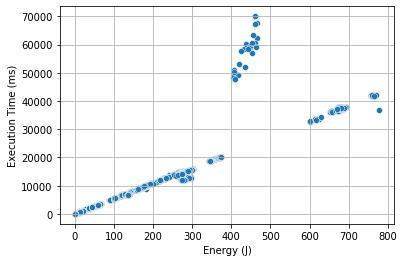

In [13]:
# data = df[(df['flag'] == '-fstg-lift-lams') & (df['program'] == 'coins')]

sns.scatterplot(df['pkg_energy'], df['execution_time'])
plt.xlabel('Energy (J)')
plt.ylabel('Execution Time (ms)')
plt.grid()
# plt.show()

plt.savefig("../../results/charts/random/energy-time-scatter.pdf")

# print(df[df['execution_time'] > 45000][['program','flag','pkg_energy','execution_time']])

corr, pvalue = stats.spearmanr(df['pkg_energy'], df['execution_time'])
print(f'Spearman\'s results \t| coef: {corr} pvalue: {pvalue}')

corr, pvalue = stats.pearsonr(df['pkg_energy'], df['execution_time'])
print(f'Pearson\'s results \t| coef: {corr} pvalue: {pvalue}')

# print(df[df['program'] == 'fasta'][['program','flag','pkg_energy','execution_time']])

# the values above 45000 ms belong to fasta when compiled with -fcase-merge, -fcase-folding and -fcall-arity


In [ ]:
neg = corr_df[corr_df['correlation'] < -0.8]

# display(corr_df[corr_df['correlation'] < 0])
for _, row in neg.iterrows():
    prog = row['program']
    flag = row['flag']

    data = df[(df['flag'] == row['flag']) & (df['program'] == row['program'])]

    sns.lmplot(x='pkg_energy', y='execution_time', data=data)
    # sns.scatterplot(data['pkg_energy'], data['execution_time'])
    plt.xlabel('Energy (J)')
    plt.ylabel('Execution Time (ms)')
    plt.grid()
    plt.show()
    print(f"""{prog} {flag} {corr_df[(corr_df['program'] == prog) & (corr_df['flag'] == flag)]['correlation']}""")